In [1]:
import os
from fnmatch import fnmatch
from trainData_featExt_glcm import trainData_featExt_glcm
from trainData_featExt_gabor import trainData_featExt_gabor
import numpy as np
from PIL import Image
from filtering.filters import Median
from feature_extraction.glcm import Glcm
from feature_extraction.gabor import Gabor
import sklearn
import time
from gmm import Gmm
from sklearn import preprocessing
import pickle

In [2]:
#Read features of training samples Gabor (30000x32)
train_samples_feats_matrix_gabor = np.load("train_samples_feats_matrix_Gabor.npy")

In [3]:
#Read features of training samples LBP (30000x26)
train_samples_feats_matrix_LBP = np.load("train_samples_feats_matrix_LBP.npy")

In [4]:
#Load features of validation samples Gabor (10000x32)
valid_samples_feats_matrix_gabor = np.load("valid_samples_feats_matrix_Gabor.npy")

In [5]:
#Load features of validation samples LBP (10000x26)
valid_samples_feats_matrix_LBP = np.load("valid_samples_feats_matrix_LBP.npy")

In [6]:
#concatenating features 
train_samples_feats_matrix_gabor_LBP = np.concatenate((train_samples_feats_matrix_gabor,train_samples_feats_matrix_LBP), axis=1)
valid_samples_feats_matrix_gabor_LBP = np.concatenate((valid_samples_feats_matrix_gabor,valid_samples_feats_matrix_LBP), axis=1)

In [ ]:
#Train a gaussian mixture model from training data
t0 = time.time()
gm_model = sklearn.mixture.GaussianMixture(n_components=10, covariance_type='spherical')
gm_model.fit(train_samples_feats_matrix_gabor_LBP)
print("traing time: ", time.time() - t0)

In [7]:
gm_model = pickle.load( open( "GMM_['Gabor', 'LBP']_1000", "rb" ))

In [8]:
#Predict labels of the new data points
y_predict = gm_model.predict(valid_samples_feats_matrix_gabor_LBP)
#Predict novelty score of new data points
y_predict_score = gm_model.score_samples(valid_samples_feats_matrix_gabor_LBP)
tmp = []

x_predict_score = gm_model.score_samples(train_samples_feats_matrix_gabor_LBP)
novelty_thresh = np.amin(x_predict_score)

#If data point belongs to the model then 1 else 0
tmp = np.repeat(1, 10000)
tmp[y_predict_score < novelty_thresh] = 0

In [9]:
#Ground truth
y1 = np.repeat(1, 6000) #normal
y2 = np.repeat(0, 4000) #abnormal
y = np.concatenate((y1,y2))

In [ ]:
fpr,tpr,thresh = sklearn.metrics.roc_curve(y, y_predict_score)
for t, thres in enumerate (thresh) :
    tmp[y_predict_score < thres] = 1
    f1 = sklearn.metrics.f1_score(y, tmp, average = 'binary')
    auc = sklearn.metrics.roc_auc_score(y, y_predict_score)
    print ("f1: ", f1, " auc: ", auc, "thres: ", thres)

In [10]:
f1_binary = sklearn.metrics.f1_score(y, tmp, pos_label =0, average = 'binary')
f1_macro = sklearn.metrics.f1_score(y, tmp, average = 'macro')
auc = sklearn.metrics.roc_auc_score(y, y_predict_score)
Math_Cof = sklearn.metrics.matthews_corrcoef(y, tmp) 
tn, fp, fn, tp  = sklearn.metrics.confusion_matrix(y, tmp).ravel()
print ("f1_binary: ", f1_binary, "f1_macro: ", f1_macro, "MAth_cof: ", Math_Cof , " auc: ", auc)
print("confusion matrix", tn, fp, fn, tp)

('f1_binary: ', 0.71688942891859053, 'f1_macro: ', 0.75946425566575226, 'MAth_cof: ', 0.51977684658812384, ' auc: ', 0.82435383333333334)
('confusion matrix', 2950, 1050, 1280, 4720)


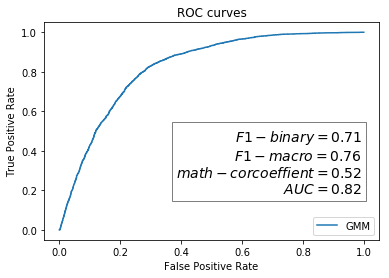

In [12]:
import matplotlib.pyplot as pl
import matplotlib
from skimage import io

fpr,tpr,thresh = sklearn.metrics.roc_curve(y, y_predict_score)

f,ax = pl.subplots(1,1)
ax.plot(fpr,tpr,label="GMM")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC curves")
ax.legend(loc="lower right")
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='square', facecolor='white', alpha=0.5)

textstr = '$F1-binary=%.2f$\n$F1-macro=%.2f$\n$math-corcoeffient=%.2f$\n$AUC=%.2f$'%(0.71, 0.76, 0.52, 0.82)
# place a text box in upper left in axes coords
ax.text(0.95, 0.2, textstr, transform=ax.transAxes, fontsize=14,
    horizontalalignment='right', verticalalignment='bottom', bbox=props)

io.show()

In [13]:
f.savefig('GMM_Gabor_LBP_1000.png')